# The Electric field of a simplified GEM

We want to simulate the electric field aroung a GEM, we will consider a simplified version with the holes in a square grid and cilindrical holes.

- Pitch = 140 um
- Dielectric thickness = 50 um
- Conductor thickness = 5 um
- Hole diameter = 70 um
- Drift field (above GEM) = 250 V/cm
- Transfer field (bellow GEM) = 3500 V/cm
- Gas gap = 1 mm
- GEM voltage

In the code all the values must be in **cm** and **V**!


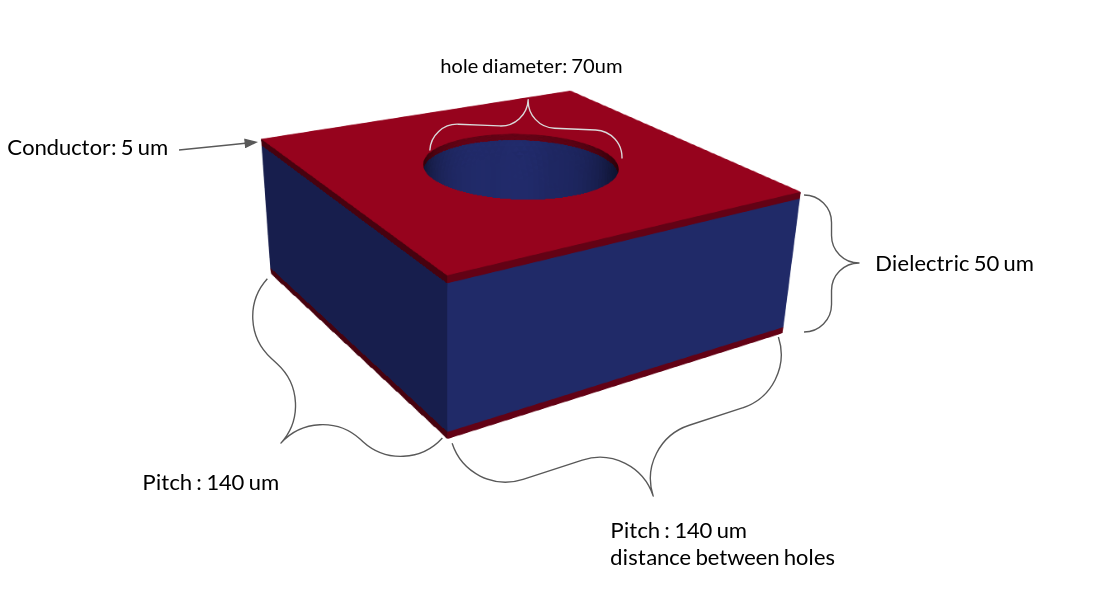

**Get the pre-compiled binaries and setup environment**

In [1]:
!wget -q -O setup.py https://raw.githubusercontent.com/swieca22/swieca22/master/setup.py
import setup
setup.install_packages()

Extracting files... ✔️
Installing dependencies.... ✔️
Loading libs... ✔️
Welcome to JupyROOT 6.22/08
All done! 🚀


## Generating mesh with gmsh

### GEM cell geometry

In [2]:
import numpy as np
import gmsh

occ = gmsh.model.occ
gmsh.initialize()

We will create and manipulate simple 3D objects to construct the GEM cell we want.

First we need to create the dielectric and conductor box using the function

`occ.addBox(x, y, z, dx, dy, dz)`

x, y, z is one of the cornes of the box
dx, dy, dz are the side lengths in the x, y, z direction

This and all the the others functions that creates new elements will return the element id, a unique number that identifies the object. All ways save those ids in variables so we can use them later.


In [ ]:
# Create dielectric box

dielectric_origin = [-pitch/2, -pitch/2, -dielectric_thickness/2]
dielectric_size = [pitch, pitch, dielectric_thickness]

dielectric_id = occ.addBox(dielectric_origin[0], dielectric_origin[1], dielectric_origin[2],
                       dielectric_size[0], dielectric_size[1], dielectric_size[2])

Now remove the conductor volume that overlaps with the dielectric using the funciton

`occ.cut(objectDimTags, toolsDimTags, removeObjects, removeTool)`

This function will cut the "object" using the "tool". The function asks for the object and tool "dimTags". It have this format:

`dimTags = [(object_dimention, object_id)]`

So for example, for the dielectric we have (dimention = 3, since this is a volume):

`dielectric_tags = [(3, dielectric_id)]`

In gmsh we dont modify the object when we apply some transformation, we always create a new one. The flags removeObjects, removeTool if set to True will remove the old objects. Here we whant to keep the tool (dielectric) but remove the old conductor box (object).

This funcion will return the dimTags of results objects plus a bunch of garbage, make sure you only keep the first part of the return data putting `[0]` and the end of the funciton call.

In [ ]:
# Cut conductor box using dielectric volume

conductor_tags = occ.cut(conductor_tags, dielectric_tags, removeObject=True, removeTool=False)[0]
conductor_tags

Now create a cylinder for the hole

`occ.addCylinder(x, y, z, dx, dy, dz, r)`

x, y, z is the origin of the cylinder axis

dx, dy, dz is size and direction of the axis

r is the radius


Make the detector hole, cutting both the dielectric and the coductors with the hole cylinder. After this will wont need the hole volume any more, you can remove it.

In [ ]:
...
print(dielectric_tags)
print(conductor_tags)

Now the final step to define the geometry, create the gas volume, a box with the same x, y size as the GEM cell but with gas gap (distance between GEM and the end of the box) of 1 mm on each direction.

Then you need to cut the gas volume that intersects the GEM cell. For this you can use both the dielectric and coductor as a tool like so:

`occ.cut(gas_tags, dielectric_tags + conductors_tags, ...)`

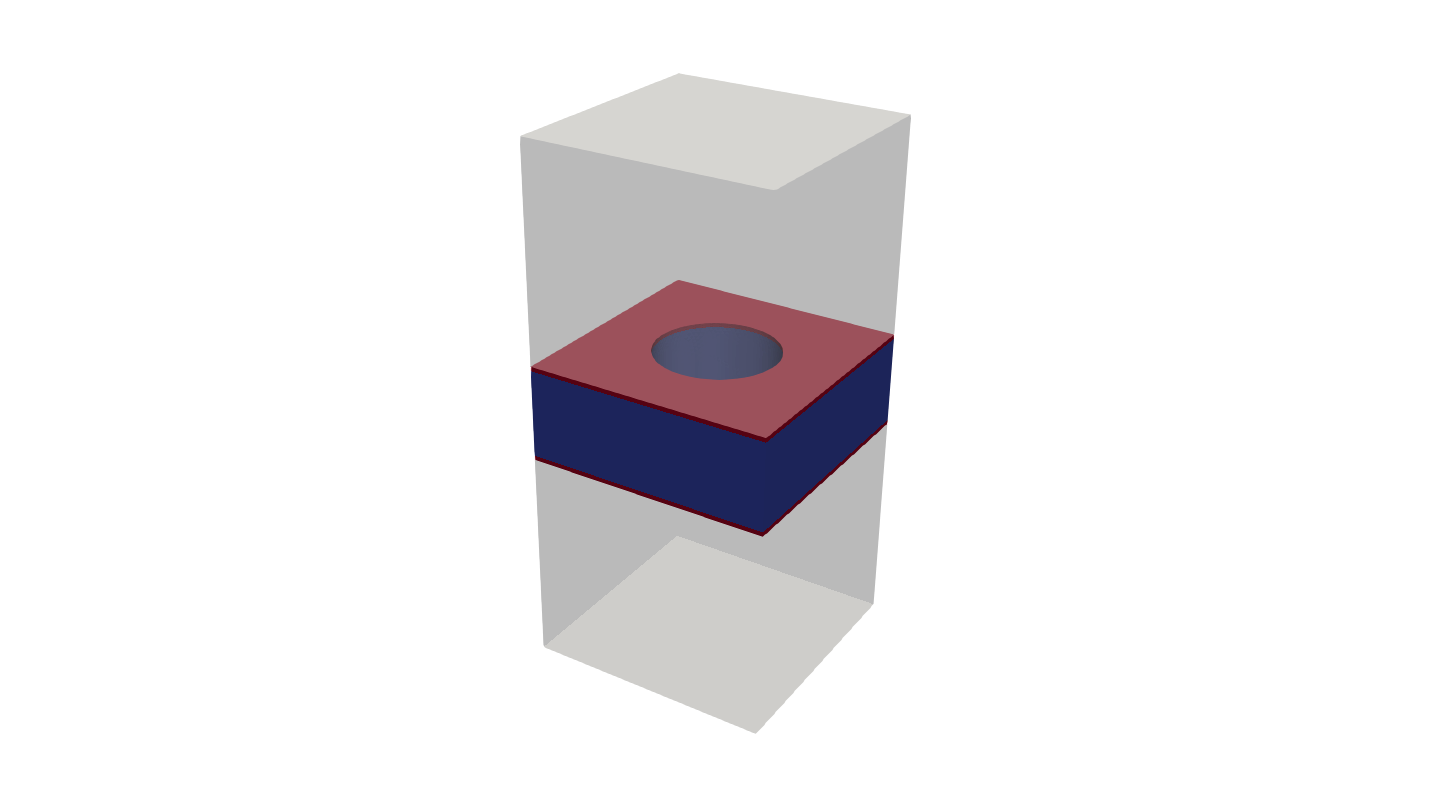

In [ ]:
...
print(gas_tags)

In [9]:
# Now a clean up step and we are done with the geometry

# Merge volume surfaces. Until now we defined independent volumes with independent surfaces.
# The following function will make sure they share common boundaries.
occ.removeAllDuplicates()

# gmsh will recreate all the entities in the removeAllDuplicates function and will try to assign the old tags to the new volumes, but this can fail.
# Check if the tags id remain the same, if not you will need to find out which tag is what
volumes_tags = occ.getEntities(dim=3)
print(volumes_tags)

occ.synchronize()

[]


### Defining physical entities

The physical entities are the ones that will be visible outside of gmsh, in Elmer and Garfield++, they need to be assing a unique id number that will be used in those programas to access them.

First we set the volumes.

In [ ]:
# Defining physical volumes
def get_ids(tags):
    "Small helper function to define physical groups"
    return [tag[1] for tag in tags]
    
dim = 3 # entity dimension (3 = volume)

gmsh.model.addPhysicalGroup(dim, get_ids(gas_tags), 1)
gmsh.model.addPhysicalGroup(dim, get_ids(dielectric_tags), 2)
gmsh.model.addPhysicalGroup(dim, get_ids(conductor_tags), 3)

Now comer the hardest part, we to do same with the surfaces that we will apply boundary conditions, for that we need to retrieve the those furfaces ids using

`occ.getEntitiesInBoundingBox(xmin, ymin, zmin, xmax, ymax, zmax, dimention)`

This function will return all entities of the defined dimention that a inside a box defined by min max values. The image bellow show all the surfaces you need to retrieve.

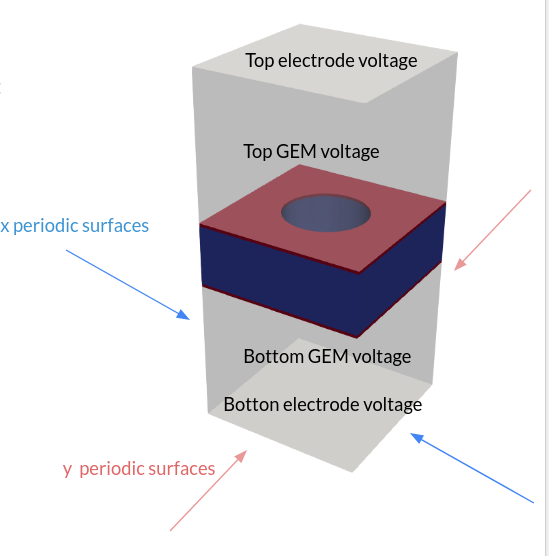


In [ ]:
# Defining physical surfaces, the ones we need to apply boundary conditions like the potentials
epsilon = 1e-6 # small value to help us defining the bounding box

# Conductor
side = pitch/2 + epsilon
height = detector_thickness/2 + epsilon

top_conductor = occ.getEntitiesInBoundingBox(-side, -side, 0,
                                             side,side, height,
                                             dim)
botton_conductor = ...

# Electrodes: cathode and anode
height = gas_box_length/2

top_gas = occ.getEntitiesInBoundingBox(-side, -side, height - epsilon, side,
                                       side, height + epsilon,
                                       dim)
botton_gas = ...

# Side surfaces
side = pitch/2
xmin = occ.getEntitiesInBoundingBox(-side -epsilon, -side -epsilon, -height -epsilon,
                                    -side + epsilon, side + epsilon, height + epsilon,
                                    dim)
xmax = ...
ymin = ...
ymax = ...

print(top_conductor)
print(botton_conductor)
print(top_gas)
print(botton_gas)
print(xmin)
print(xmax)
print(ymin)
print(ymax)

In [ ]:
gmsh.model.addPhysicalGroup(dim, get_ids(top_gas), 1)
gmsh.model.addPhysicalGroup(dim, get_ids(top_conductor), 2)
gmsh.model.addPhysicalGroup(dim, get_ids(botton_conductor), 3)
gmsh.model.addPhysicalGroup(dim, get_ids(botton_gas), 4)

gmsh.model.addPhysicalGroup(dim, get_ids(xmin), 5)
gmsh.model.addPhysicalGroup(dim, get_ids(xmax), 6)
gmsh.model.addPhysicalGroup(dim, get_ids(ymin), 7)
gmsh.model.addPhysicalGroup(dim, get_ids(ymax), 8)

8

Now we can set the mesh size

In [ ]:
# Set overall mesh size
all_points = gmsh.model.getEntities(dim=0)
gmsh.model.mesh.set_size(all_points, overal_mesh_size)

# Refining mesh around GEM conductors
conductor_points = gmsh.model.getBoundary(top_conductor + botton_conductor, False, False, True)
gmsh.model.mesh.set_size(conductor_points, conductor_mesh_size)

In [13]:
# Generating mesh
# After the meshing is done download the gemcell.vtk file to see it in paraview.

gmsh.option.setNumber("Mesh.ElementOrder", 2)
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.model.mesh.generate(3)
gmsh.write("gemcell.msh")
gmsh.write("gemcell.vtk")
gmsh.finalize()

Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 5.5303e-05s, CPU 6.2e-05s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 5.0688e-05s, CPU 4.5e-05s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 5.2197e-05s, CPU 4.6e-05s)
Info    : Meshing order 2 (curvilinear on)...
Info    : Done meshing order 2 (Wall 4.889e-06s, CPU 4e-06s)
Info    : 0 nodes 0 elements
Info    : Writing 'gemcell.msh'...
Info    : Done writing 'gemcell.msh'
Info    : Writing 'gemcell.vtk'...
Info    : Done writing 'gemcell.vtk'


## Solving electric field with Elmer

In [ ]:
# First we convert our mesh to the Elmer format
!ElmerGrid 14 2 gemcell.msh


Starting program Elmergrid
Elmergrid reading in-line arguments
Output will be saved to file gemcell.

Elmergrid loading data:
-----------------------
Format chosen using the first line: $MeshFormat
Gmsh version is 2.2
Loading mesh in Gmsh format 2.0 from file gemcell.msh
Allocating for 144324 knots and 119023 elements.
Moving bulk elements to boundary elements
Leading bulk elementtype is 510
Trailing bulk elementtype is 306
There are 18640 (out of 119023) lower dimensional elements.
Node 77164 belongs to maximum of 54 elements
Found 6432 side elements that have two parents.
Found correctly 18640 side elements.
Parent elements were reordered up to index 100383.
Moved 100383 elements (out of 119023) to new positions
Successfully read the mesh from the Gmsh input file.
Using physical numbering of entities

Elmergrid creating and manipulating meshes:
-------------------------------------------

Elmergrid saving data with method 2:
-------------------------------------
Saving mesh in Elmer

Now you need write the Solver Input File for Elmer, it will insctruc how Elmer will solve the field. We create a function and the only thing that is missing is the definition of some of the boundary conditions.

In [ ]:
def write_sif(deltaV, gas_gap, Edrift=250, Etrans=1e3):
    """
    deltaV: [V] Voltage through GEM
    gas_gap: [cm] Distance between GEM surfaces and electrodes (cathode and anode)
    Edrift: [V/cm] Drift field
    Etrans: [V/cm] Transfer field"""

    text=f"""
Check Keywords Warn

Header
  Mesh DB "." "gemcell"
End

Simulation
  Coordinate System = Cartesian 3D
  Simulation Type = Steady State
  Steady State Max Iterations = 1
  Output File = "gemcell.result"
  Post File = "gemcell.vtu"
End

Constants
  Permittivity Of Vacuum = 8.8542e-12
End

Body 1
  Equation = 1
  Material = 1
End

Body 2
  Equation = 1
  Material = 2
End

Body 3
  Equation = 1
  Material = 3
End

Equation 1
  Active Solvers(1) = 1
  Calculate Electric Energy = True
End

Solver 1
  Equation = Stat Elec Solver
  Variable = Potential
  Variable DOFs = 1
  Procedure = "StatElecSolve" "StatElecSolver"
  Calculate Electric Field = True
  Calculate Electric Flux = False
  Linear System Solver = Iterative
  Linear System Iterative Method = BiCGStab
  Linear System Max Iterations = 1000
  Linear System Abort Not Converged = True
  Linear System Convergence Tolerance = 1.0e-10
  Linear System Preconditioning = ILU1
  Steady State Convergence Tolerance = 5.0e-7
!  Adaptive Mesh Refinement = True
!  Adaptive Remesh = True
!  Adaptive Save Mesh = True
!  Adaptive Error Limit = 1.0e-12
End

! Gas
Material 1
  Relative Permittivity = 1
  Density = 1
End

! Dielectric
Material 2
  Relative Permittivity = 3.23
  Density = 2
End

! Conductor
Material 3
  Relative Permittivity = 1e10
  Density = 3
End

! Upper electrode
! Set the potential for this boundary

! Upper copper plate
! Set the potential for this boundary

! Lower copper plate
! Set the potential for this boundary

! Lower electrode
Boundary Condition 4
  Target Boundaries = 4
  Potential = 0
End

! Set up boundary xmin
Boundary Condition 5
  Target Boundaries = 5
End
! Link to xmax
Boundary Condition 6
  Target Boundaries = 6
  Periodic BC = 5
  Periodic BC Potential = Logical True
End

! Set up boundary for ymin
! Set ymin and ymax with a periodic boundary condition
"""

    with open("gemcell.sif", "w") as file:
        file.write(text)


In [ ]:
write_sif(deltaV=deltaV, gas_gap=gas_gap, transfer_field, drift_field)

In [ ]:
!ElmerSolver gemcell.sif

ELMER SOLVER (v 9.0) STARTED AT: 2022/07/28 07:00:17
ParCommInit:  Initialize #PEs:            1
MAIN: 
MAIN: =============================================================
MAIN: ElmerSolver finite element software, Welcome!
MAIN: This program is free software licensed under (L)GPL
MAIN: Copyright 1st April 1995 - , CSC - IT Center for Science Ltd.
MAIN: Webpage http://www.csc.fi/elmer, Email elmeradm@csc.fi
MAIN: Version: 9.0 (Rev: cdd726ff, Compiled: 2022-07-01)
MAIN:  Running one task without MPI parallelization.
MAIN:  Running with just one thread per task.
MAIN: =============================================================
MAIN: 
MAIN: 
MAIN: -------------------------------------
MAIN: Reading Model: gemcell.sif
LoadInputFile: Scanning input file: gemcell.sif
LoadInputFile: Scanning only size info
LoadInputFile: First time visiting
LoadInputFile: Reading base load of sif file
LoadInputFile: Loading input file: gemcell.sif
LoadInputFile: Reading base load of sif file
CheckKeyword:  

## Visualizing mesh and field with Garfield

Define the `pitch` variable in cm for this to work

In [ ]:
import ROOT

with open("gemcell/dielectrics.dat", "w") as file:
    text = """3
1 1
2 3.23
3 1e10
"""
    file.write(text)

elm = ROOT.Garfield.ComponentElmer("gemcell/mesh.header", "gemcell/mesh.elements", "gemcell/mesh.nodes",
                                        "gemcell/dielectrics.dat", "gemcell/gemcell.result", "cm")
elm.EnablePeriodicityX()
elm.EnablePeriodicityY()

ComponentElmer::Initialise:
    Read 144324 nodes and 100383 elements from file gemcell/mesh.header.
ComponentElmer::Initialise:
    Set material 0 of 3 to eps 1.
ComponentElmer::Initialise:
    Set material 1 of 3 to eps 3.23.
ComponentElmer::Initialise:
    Set material 2 of 3 to eps 1e+10.
ComponentElmer::Initialise: Finished.
ComponentElmer::Prepare:
    Caching the bounding boxes of all elements... done.
ComponentElmer::InitializeTetrahedralTree: Success.


In [ ]:
# Plot side geometry
cGeom = ROOT.TCanvas("geom", "Geometry")
viewMesh = ROOT.Garfield.ViewFEMesh()
viewMesh.SetCanvas(cGeom)
viewMesh.SetComponent(elm)
viewMesh.SetArea(-pitch, -pitch/2, -pitch, pitch, pitch/2, pitch)
viewMesh.SetPlane(0, -1, 0, 0, 0, 0)
viewMesh.SetFillMesh(True)
viewMesh.SetColor(1,ROOT.kGray)
viewMesh.SetColor(2,ROOT.kYellow + 3)
viewMesh.EnableAxes()
viewMesh.SetXaxisTitle("x (cm)")
viewMesh.SetYaxisTitle("z (cm)")
viewMesh.Plot()
cGeom.Draw()

In [ ]:
# Plot top geometry
viewMesh.SetArea(-pitch, -pitch, -pitch, pitch,  pitch, pitch)
viewMesh.SetPlane(0, 0, -1, 0, 0, 0)
viewMesh.SetXaxisTitle("x (cm)")
viewMesh.SetYaxisTitle("y (cm)")
viewMesh.Plot()
cGeom.Draw()

In [ ]:
# Plot electric field magnitude
cFields = ROOT.TCanvas("fields", "Fields")
viewField = ROOT.Garfield.ViewField()
viewField.SetComponent(elm)
viewField.SetCanvas(cFields)
viewField.SetArea(-pitch, -pitch/2, pitch, pitch/2)
viewField.SetPlane(0, -1, 0, 0, 0, 0)
viewField.Plot("e", "colz")
cFields.Draw()